# Reversible

This is for an integrated test of E-Cell4. Here, we test a simple reversible association/dissociation model in volume.

In [1]:
%matplotlib inline
import numpy
from ecell4 import *

Parameters are given as follows. `D`, `radius`, `N_A`, `U`, and `ka_factor` mean a diffusion constant, a radius of molecules, an initial number of molecules of `A` and `B`, a ratio of dissociated form of `A` at the steady state, and a ratio between an intrinsic association rate and collision rate defined as `ka` and`kD` below, respectively. Dimensions of length and time are assumed to be micro-meter and second.

In [2]:
D = 1
radius = 0.005
N_A = 60
U = 0.5
ka_factor = 0.1  # 0.1 is for reaction-limited

Calculating optimal reaction rates. `ka` and `kd` are intrinsic, `kon` and `koff` are effective reaction rates.

In [3]:
kD = 4 * numpy.pi * (radius * 2) * (D * 2)
ka = kD * ka_factor
kd = ka * N_A * U * U / (1 - U)
kon = ka * kD / (ka + kD)
koff = kd * kon / ka

Start with no `C` molecules, and simulate 3 seconds.

In [4]:
y0 = {'A': N_A, 'B': N_A}
T = numpy.linspace(0, 3, 101)

Make a model with effective rates. This model is for macroscopic simulation algorithms.

In [5]:
with species_attributes():
    A | B | C | {'radius': str(radius), 'D': str(D)}

with reaction_rules():
    A + B == C | (kon, koff)

m = get_model()

Save a result with `ode` as `obs`, and plot it:

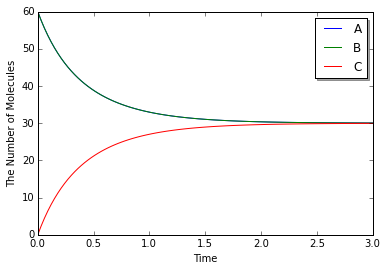

In [6]:
obs = run_simulation(T, y0, model=ode.ODENetworkModel(m), return_type='observer',
                     solver='ode')
viz.plot_number_observer(obs)

Simulating with `gillespie`:

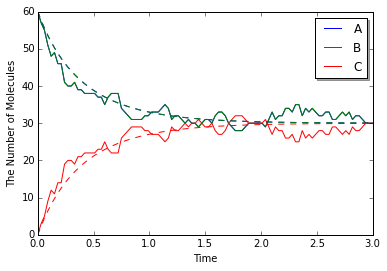

In [7]:
run_simulation(T, y0, model=m, return_type='matplotlib', plot_args=('-', obs, '--'),
               solver='gillespie')

Simulating with `meso`:

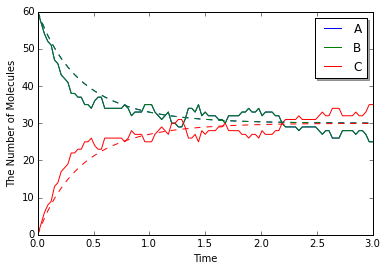

In [8]:
run_simulation(T, y0, model=m, return_type='matplotlib', plot_args=('-', obs, '--'),
               factory=meso.MesoscopicFactory(0.25))

Make a model with intrinsic rates. This model is for microscopic (particle) simulation algorithms.

In [9]:
with species_attributes():
    A | B | C | {'radius': str(radius), 'D': str(D)}

with reaction_rules():
    A + B == C | (ka, kd)

m = get_model()

Simulating with `lattice`. `voxel_radius` is given as `radius`:

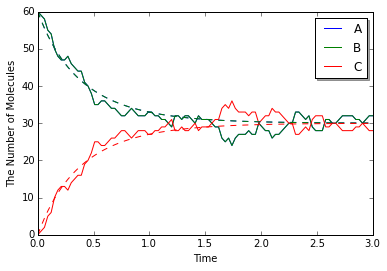

In [10]:
run_simulation(T, y0, model=m, return_type='matplotlib', plot_args=('-', obs, '--'),
               factory=lattice.LatticeFactory(radius))

Simulating with `egfrd`:

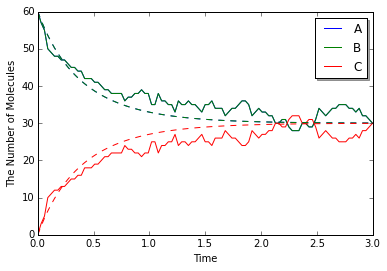

In [11]:
run_simulation(T, y0, model=m, return_type='matplotlib', plot_args=('-', obs, '--'),
               solver='egfrd')